In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]

# Lectura de Datos

In [4]:
movil=pd.read_csv('datasets/Telefonia_movil.csv',  dayfirst=True, thousands='.')
movil.tail()

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
17,2017,2,15315167,6293563,21608730,Abr-Jun 2017
18,2017,3,15106275,6308373,21414647,Jul-Sept 2017
19,2017,4,14164552,5380710,19545262,Oct-Dic 2017
20,2018,1,13851254,5958717,19809971,Ene-Mar 2018
21,2018,2,14388755,6290155,20678910,Abr-Jun 2018


In [5]:
movil.index = pd.PeriodIndex((movil['Año'].astype(str) + "Q" + movil["Trimestre"].astype(str)), freq='Q')
movil.head()

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
2013Q1,2013,1,8785943,6582117,15368060,Ene-Mar 2013
2013Q2,2013,2,9512689,7108640,16621329,Abr-Jun 2013
2013Q3,2013,3,10315484,7335154,17650638,Jul-Sept 2013
2013Q4,2013,4,9809515,6250549,16060064,Oct-Dic 2013
2014Q1,2014,1,10128751,5799223,15927974,Ene-Mar 2013


Se utiliza los minutos de prepago Saliente para el trabajo 


In [8]:
colName = 'Minutos prepago salientes (miles)'
y=movil[colName]

Exploración de Datos

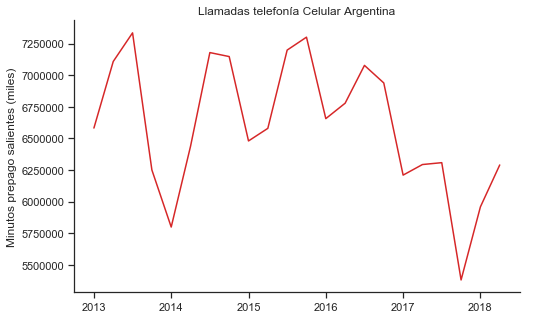

In [9]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel(colName)
ax.set_title('Llamadas telefonía Celular Argentina')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

 Comparación de Trimestres en los diferentes Años

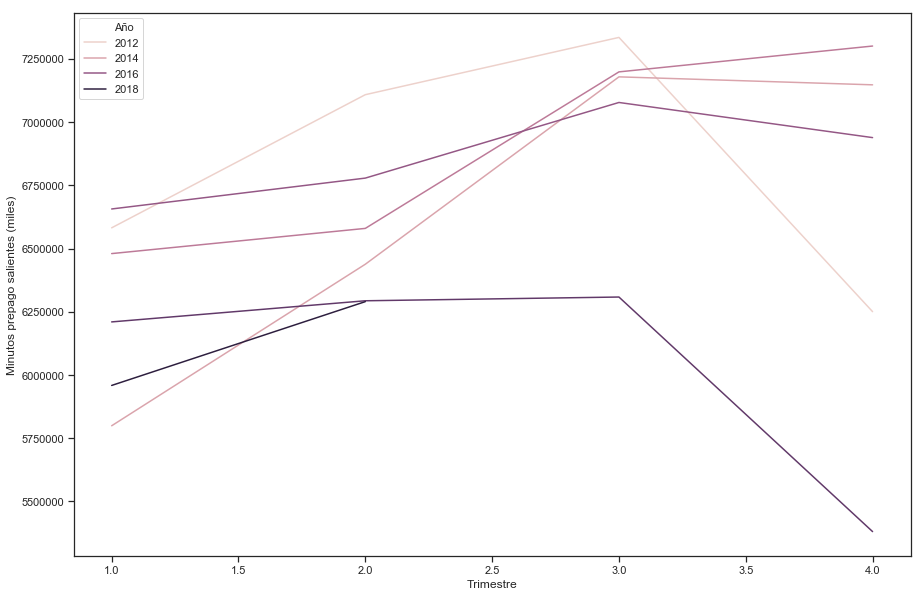

In [12]:
sns.lineplot('Trimestre',colName,hue='Año', data=movil, markers='None');

# Comentarios
No se visualiza estacionalidad marcada

Box Plot

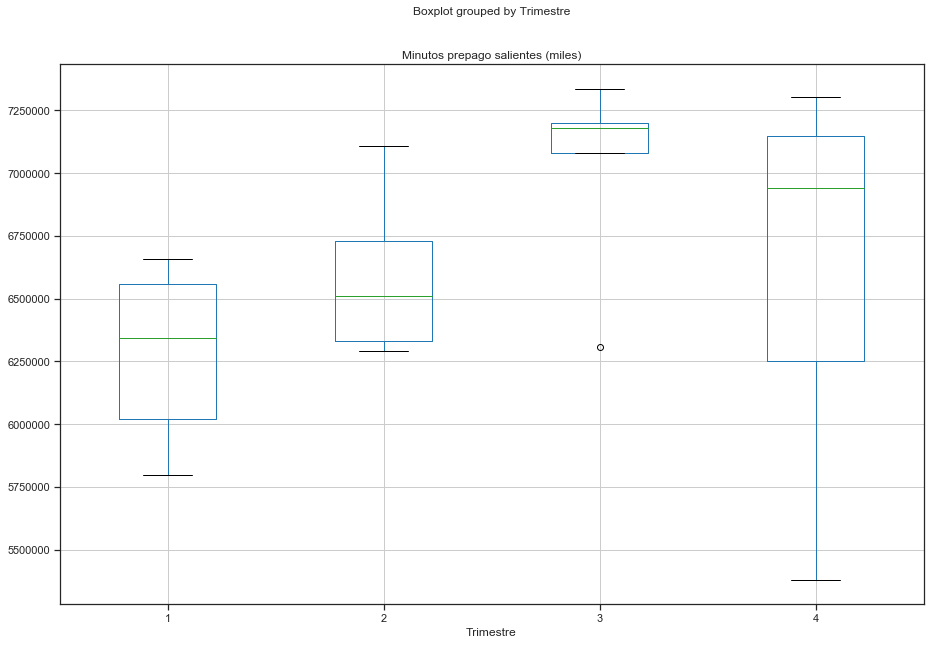

In [25]:
movil.boxplot(column=colName,by='Trimestre');

# Comentarios
Si bien se puede apreciar que el 3 trimestre es el Q con mayor cantidad de minutos de llamadas.. el 4 Q es un trimestres con mucha variación de minutos a lo largo de los años

In [15]:
y.describe().round(2)

count         22.00
mean     6604272.82
std       525180.47
min      5380710.00
25%      6291007.00
50%      6580968.00
75%      7100939.50
max      7335154.00
Name: Minutos prepago salientes (miles), dtype: float64

## Random walk



In [26]:
h = 4
test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')
pred=pd.Series(np.repeat(y.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
pred

2018Q3    6290155
2018Q4    6290155
2019Q1    6290155
2019Q2    6290155
Freq: Q-DEC, dtype: int64

Using the formulas from the lecture, the interval forecasts are as below. 

In [27]:
resid=y-y.shift(1) # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)

542855.357

In [28]:
intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2018Q3,5226178.052,7354131.948
2018Q4,4785464.370,7794845.630
2019Q1,4447292.868,8133017.132
2019Q2,4162201.104,8418108.896


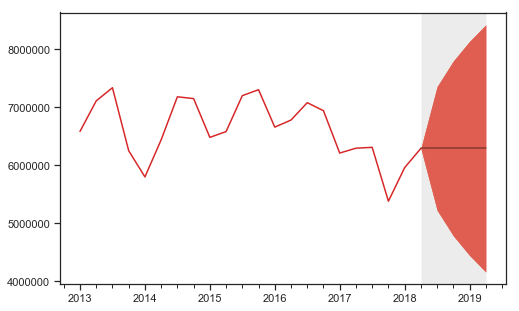

In [29]:
from plotting import fanchart

point_pred = (intv[0]+intv[1])/2

fig, ax = fanchart(y['2013':],point_pred,intv,intv,intv)

plt.show()

## Simple exponential smoothing



In [96]:
model_ses = sm.tsa.SimpleExpSmoothing(y).fit(smoothing_level=0.6)
fitted_ses = model_ses.fittedvalues
# model_ses.summary() # summary isn't implemented in 0.9, looks it'll be avaible in 0.10
alpha_ses = model_ses.model.params['smoothing_level']
mse_ses = sm.tools.eval_measures.mse(y,fitted_ses)
# loglik_ses = model_ses.model.loglike(model_ses.model.params) # NotImplementedError
aic_ses = model_ses.aic
bic_ses = model_ses.bic
print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_ses))
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))


 Smoothing parameter: alpha  0.600
 In-sample fit:
 MSE               258033149390.482
 AIC               582.080
 BIC               584.262


Also AIC and BIC looks off so we are continue our analysis with MSE. Also they are fixed in 0.10. In the case you need them, you can calculate them as it follows

In [97]:
N = len(y)
loglik_ses=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_ses)
aic_ses=-2*loglik_ses+2*3
bic_ses=-2*loglik_ses+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))

 Log-likelihood    -320.257
 AIC               646.513
 BIC               649.786


Now, let's see how the smoothed data fits the original data

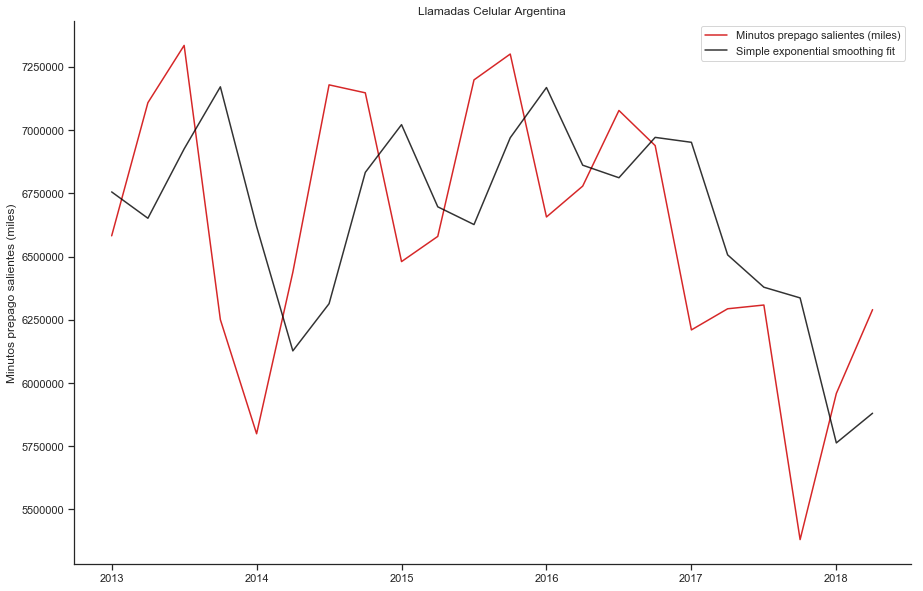

In [98]:
fig, ax= plt.subplots(figsize=(15,10))
y.plot(color=red, label=colName)
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel(colName)
ax.set_title('Llamadas Celular Argentina')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

## Model diagnostics

We now conduct residual diagnostics for the exponential smoothing. Recall from the lectures that the key diagnostics for univariate time series are: 

1. Residual plot.
2. Residual autocorrelation function (ACF) plot.
3. Residual distribution plots.

We compute the residuals as follows.

In [99]:
resid=y-fitted_ses # model_ses.resid isn't a panda.Series, so no index, no plot

The following cells compute the diagnostics. We find that the residuals are uncorrelated, have non-constant variance (due to higher volatitility in the 80s), and are non-Gaussian. 

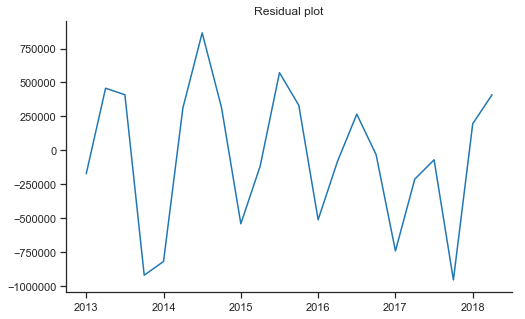

In [100]:
fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

Plotting histogram (in blue) and kernel density estimation (in black) for the residuals

C:\Users\lgrando\AppData\Local\conda\conda\envs\diplodatos-ayv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


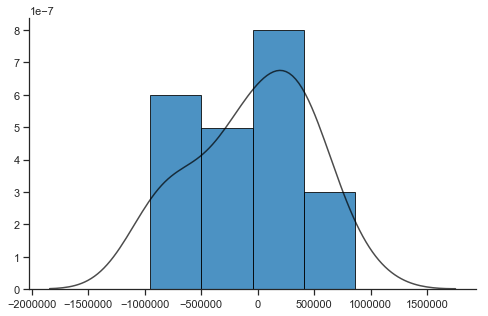

In [101]:
def hist(series):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid)
plt.show()

## Model validation


In [117]:
# Real time forecasting - use it as a template - expanding window

validation=y['2016Q1':].index # the validation period is Q1 2004 onwards
start = y.index.get_loc('2016Q1') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-1]) # random walk forecast
    model = sm.tsa.SimpleExpSmoothing(y.iloc[:i]).fit() 
    pred2.append(int(model.forecast(1)[0])) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)
results_sm.tail()

,RW,SES,Actual
2017Q2,6209983,6768568,6293563
2017Q3,6293563,6741957,6308373
2017Q4,6308373,6718869,5380710
2018Q1,5380710,6652595,5958717
2018Q2,5958717,5965195,6290155


Se visualiza que Random Walk se ajusta mejor

In [118]:
from scipy import stats

table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm.iloc[:,i], results_sm.iloc[:,-1])
    table.iloc[i,1] = (results_sm.iloc[:,i] - results_sm.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
RW,488050.341,159155.504
SES,572028.943,164764.433


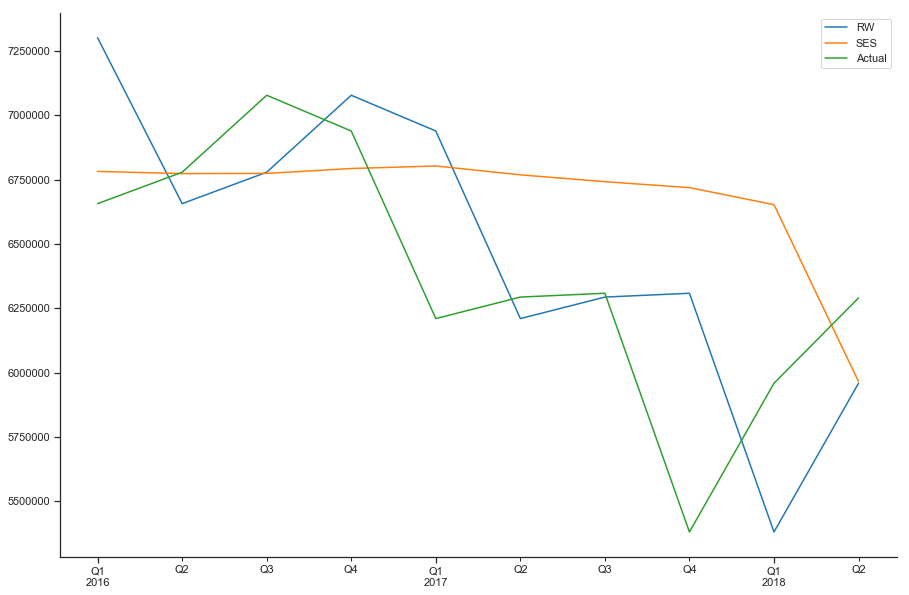

In [119]:
results_sm.plot(label='Duración llamadas')
sns.despine()
plt.show()